# Bayesian Regression - Introduction (Part 1)
線形回帰の話  
dataset $\mathcal{D}$ 

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

学習可能なパラメータ：重みwとバイアスbノイズ$\epsilon$

$$ y = w X + b + \epsilon $$

線形回帰による点推定に不確実性をpyroによって組み込んでベイズ回帰を実装する

## Setup
必要なモジュール

In [1]:
%reset -s -f

In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

### Dataset 

凸凹な地形が経済にどのような影響を与えるか：アフリカでは良い影響，その他の地域ではマイナスの影響を与えるらしい？
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
GDPはかなりの傾斜があるのでlogをとる

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

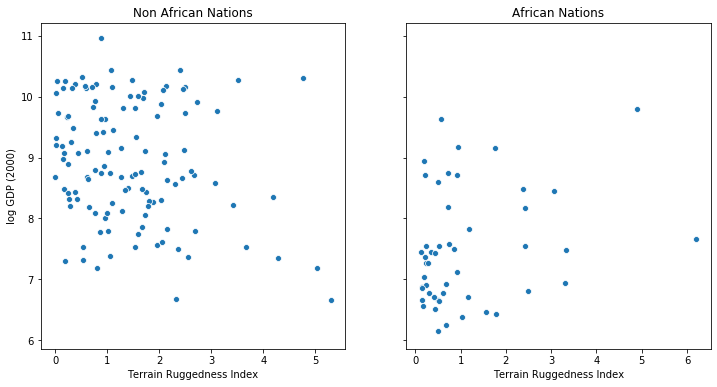

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            non_african_nations["rgdppc_2000"], 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
                african_nations["rgdppc_2000"], 
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Linear Regression

GDPをアフリカにあるか(0,1)と地形の凸凹さから予測する
- 学習させたいパラメータをpytorchはnn.Parameterのインスタンスになる
  - Learnable parameters in PyTorch modules are instances of `nn.Parameter`, in this case the `weight` and `bias` parameters of the `nn.Linear` class. When declared inside a `PyroModule` as attributes, these are automatically registered in Pyro's param store. While this model does not require us to constrain the value of these parameters during optimization, this can also be easily achieved in `PyroModule` using the [PyroParam](http://docs.pyro.ai/en/dev/nn.html#pyro.nn.module.PyroParam) statement. 
  - Note that while the `forward` method of `PyroModule[nn.Linear]` inherits from `nn.Linear`, it can also be easily overridden. e.g. in the case of logistic regression, we apply a sigmoid transformation to the linear predictor.

In [5]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


### Training with PyTorch Optimizers

Note that in addition to the two features `rugged` and `cont_africa`, we also include an interaction term in our model, which lets us separately model the effect of ruggedness on the GDP for nations within and outside Africa.
interaction termなるものによってcont_africaの値でruggednessの学習を分ける(2つの線形回帰モデルを作成する)ことができる

We use the mean squared error (MSE) as our loss and Adam as our optimizer from the `torch.optim` module. We would like to optimize the parameters of our model, namely the `weight` and `bias` parameters of the network, which corresponds to our regression coefficents and the intercept.

In [6]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

            
# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7852
[iteration 0100] loss: 1616.1372
[iteration 0150] loss: 1109.4120
[iteration 0200] loss: 833.7545
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9385
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

### Plotting the Regression Fit

Let us plot the regression fit for our model, separately for countries outside and within Africa.

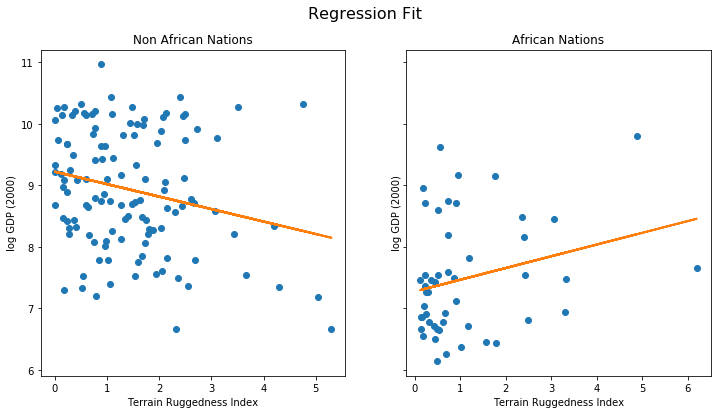

In [7]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

地形の凸凹さと地域(アフリカ，非アフリカ)とGDPに相関があるらしいことは分かったがこの傾向のロバスト性が知りたい  
パラメータの不確実性によってどれくらい回帰モデルが変化するのか知りたい  
→ベイズ回帰モデルを作って観測データによる分布を推論する


## Bayesian Regression with Pyro's Stochastic Variational Inference (SVI)

### Model

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

Making a Bayesian model for linear regression is very intuitive using `PyroModule` as earlier. Note the following:

 - The `BayesianRegression` module internally uses the same `PyroModule[nn.Linear]` module. However, note that we replace the `weight` and the `bias` of the this module with `PyroSample` statements. These statements allow us to place a prior over the `weight` and `bias` parameters, instead of treating them as fixed learnable parameters. For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.
 - The `BayesianRegression.forward` method specifies the generative process. We generate the mean value of the response by calling the `linear` module (which, as you saw, samples the `weight` and `bias` parameters from the prior and returns a value for the mean response). Finally we use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`. The model returns the regression line given by the variable `mean`.

In [8]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [11]:
from pyro.distributions import Normal

In [15]:
x = pyro.sample("x", Normal(0,1).expand([10]).to_event(1))
print(x.shape)

torch.Size([10])


### Using an AutoGuide

In order to do inference, i.e. learn the posterior distribution over our unobserved parameters, we will use Stochastic Variational Inference (SVI). The guide determines a family of distributions, and `SVI` aims to find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior. 

Users can write arbitrarily flexible custom guides in Pyro, but in this tutorial, we will restrict ourselves to Pyro's [autoguide library](http://docs.pyro.ai/en/dev/infer.autoguide.html). In the next [tutorial](bayesian_regression_ii.ipynb), we will explore how to write guides by hand.

To begin with, we will use the `AutoDiagonalNormal` guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see in [Part II](bayesian_regression_ii.ipynb)). Under the hood, this defines a `guide` that uses a `Normal` distribution with learnable parameters corresponding to each `sample` statement in the model. e.g. in our case, this distribution should have a size of `(5,)` correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and `sigma` in the model. 

Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/infer.autoguide.html) for more information).

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

### Optimizing the Evidence Lower Bound

We will use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)) for doing inference. Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [10]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

Note that we use the `Adam` optimizer from Pyro's `optim` module and not the `torch.optim` module as earlier. Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). Optimizers in `pyro.optim` are used to optimize and update parameter values in Pyro's parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the `SVI` class automatically. To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to `SVI.step` will be passed to both `model()` and `guide()`. The complete training loop is as follows:

In [11]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5253
[iteration 0201] loss: 3.2347
[iteration 0301] loss: 3.0890
[iteration 0401] loss: 2.6377
[iteration 0501] loss: 2.0626
[iteration 0601] loss: 1.4852
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4940
[iteration 1101] loss: 1.4988
[iteration 1201] loss: 1.4938
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


We can examine the optimized parameter values by fetching from Pyro's param store.

In [12]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3791,  9.1823])
AutoDiagonalNormal.scale tensor([0.0551, 0.1142, 0.0387, 0.0769, 0.0702])


As you can see, instead of just point estimates, we now have uncertainty estimates (`AutoDiagonalNormal.scale`) for our learned parameters. Note that Autoguide packs the latent variables into a single tensor, in this case, one entry per variable sampled in our model. Both the `loc` and `scale` parameters have size `(5,)`, one for each of the latent variables in the model, as we had remarked earlier.

To look at the distribution of the latent parameters more clearly, we can make use of the `AutoDiagonalNormal.quantiles` method which will unpack the latent samples from the autoguide, and automatically constrain them to the site's support (e.g. the variable `sigma` must lie in `(0, 10)`). We see that the median values for the parameters are quite close to the Maximum Likelihood point estimates we obtained from our first model.

In [13]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9328), tensor(0.9647), tensor(0.9976)],
 'linear.weight': [tensor([[-1.8868, -0.1952,  0.3272]]),
  tensor([[-1.8097, -0.1691,  0.3791]]),
  tensor([[-1.7327, -0.1429,  0.4309]])],
 'linear.bias': [tensor([9.1350]), tensor([9.1823]), tensor([9.2297])]}

## Model Evaluation

To evaluate our model, we'll generate some predictive samples and look at the posteriors. For this we will make use of the [Predictive](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive) utility class.

  - We generate 800 samples from our trained model. Internally, this is done by first generating samples for the unobserved sites in the `guide`, and then running the model forward by conditioning the sites to values sampled from the `guide`. Refer to the [Model Serving](#Model-Serving-via-TorchScript) section for insight on how the `Predictive` class works.
  - Note that in `return_sites`, we specify both the outcome (`"obs"` site) as well as the return value of the model (`"_RETURN"`) which captures the regression line. Additionally, we would also like to capture the regression coefficients (given by `"linear.weight"`) for further analysis.
  - The remaining code is simply used to plot the 90% CI for the two variables from our model.

In [14]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, 
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [15]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

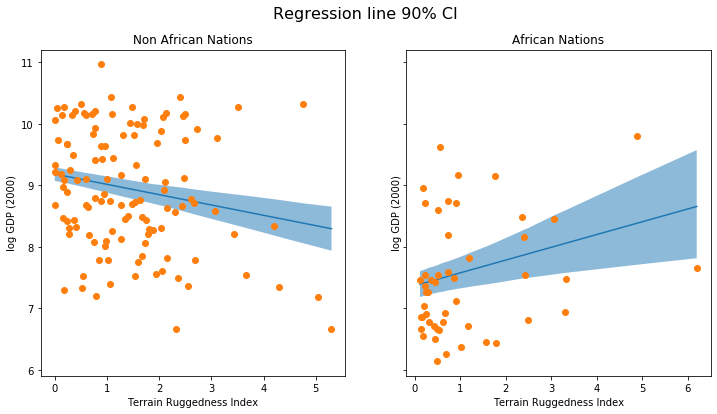

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

The above figure shows the uncertainty in our estimate of the regression line, and the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by `sigma`! Let us do so next.

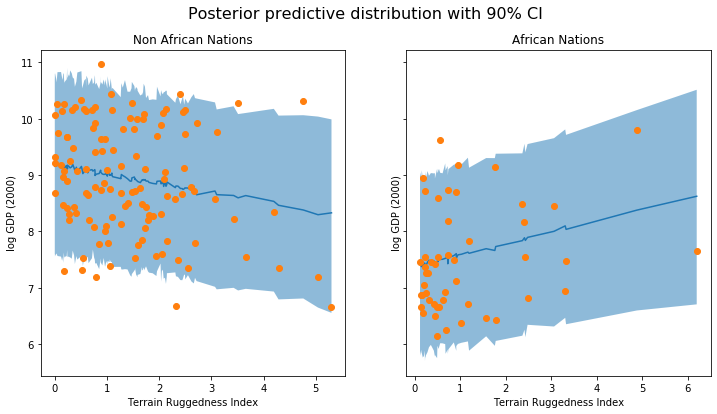

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions. 

Finally, let us revisit our earlier question of how robust the relationship between terrain ruggedness and GDP is against any uncertainty in the parameter estimates from our model. For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa. As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations, lending further credence to the original hypothesis. 

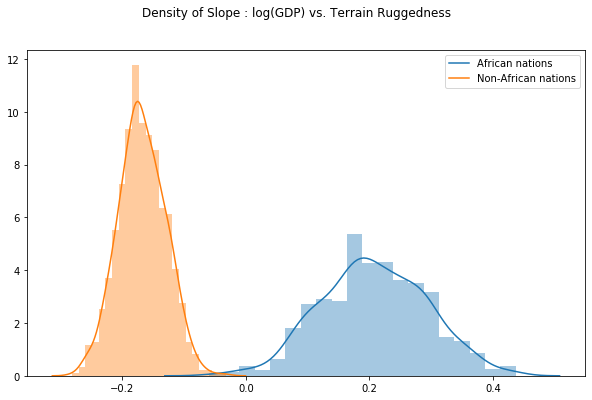

In [18]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Model Serving via TorchScript

Finally, note that the `model`, `guide` and the `Predictive` utility class are all `torch.nn.Module` instances, and can be serialized as [TorchScript](https://pytorch.org/docs/stable/jit.html). 

Here, we show how we can serve a Pyro model as a [torch.jit.ModuleScript](https://pytorch.org/docs/stable/jit.html#torch.jit.ScriptModule), which can be run separately as a C++ program without a Python runtime.

To do so, we will rewrite our own simple version of the `Predictive` utility class using Pyro's [effect handling library](http://pyro.ai/examples/effect_handlers.html). This uses:

 - the `trace` poutine to capture the execution trace from running the model/guide code.
 - the `replay` poutine to condition the sites in the model to values sampled from the guide trace.
 

In [19]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings


class Predict(torch.nn.Module):
    def __init__(self, model, guide):
        super().__init__()
        self.model = model
        self.guide = guide
        
    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

predict_fn = Predict(model, guide)
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

We use [torch.jit.trace_module](https://pytorch.org/docs/stable/jit.html#torch.jit.trace_module) to trace the `forward` method of this module and save it using [torch.jit.save](https://pytorch.org/docs/stable/jit.html#torch.jit.save). This saved model `reg_predict.pt` can be loaded with PyTorch's C++ API using `torch::jit::load(filename)`, or using the Python API as we do below. 

In [20]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')
pred_loaded(x_data)

(tensor([9.2165]),
 tensor([[-1.6612, -0.1498,  0.4282]]),
 tensor([ 7.5951,  8.2473,  9.3864,  9.2590,  9.0540,  9.3915,  8.6764,  9.3775,
          9.5473,  9.6144, 10.3521,  8.5452,  5.4008,  8.4601,  9.6219,  9.7774,
          7.1958,  7.2581,  8.9159,  9.0875,  8.3730,  8.7903,  9.3167,  8.8155,
          7.4433,  9.9981,  8.6909,  9.2915, 10.1376,  7.7618, 10.1916,  7.4754,
          6.3473,  7.7584,  9.1307,  6.0794,  8.5641,  7.8487,  9.2828,  9.0763,
          7.9250, 10.9226,  8.0005, 10.1799,  5.3611,  8.1174,  8.0585,  8.5098,
          6.8656,  8.6765,  7.8925,  9.5233, 10.1269, 10.2661,  7.8883,  8.9194,
         10.2866,  7.0821,  8.2370,  8.3087,  7.8408,  8.4891,  8.0107,  7.6815,
          8.7497,  9.3551,  9.9687, 10.4804,  8.5176,  7.1679, 10.8805,  7.4919,
          8.7088,  9.2417,  9.2360,  9.7907,  8.4934,  7.8897,  9.5338,  9.6572,
          9.6604,  9.9855,  6.7415,  8.1721, 10.0646, 10.0817,  8.4503,  9.2588,
          8.4489,  7.7516,  6.8496,  9.2208,  8.98

Let us check that our `Predict` module was indeed serialized correctly, by generating samples from the loaded module and regenerating the previous plot.

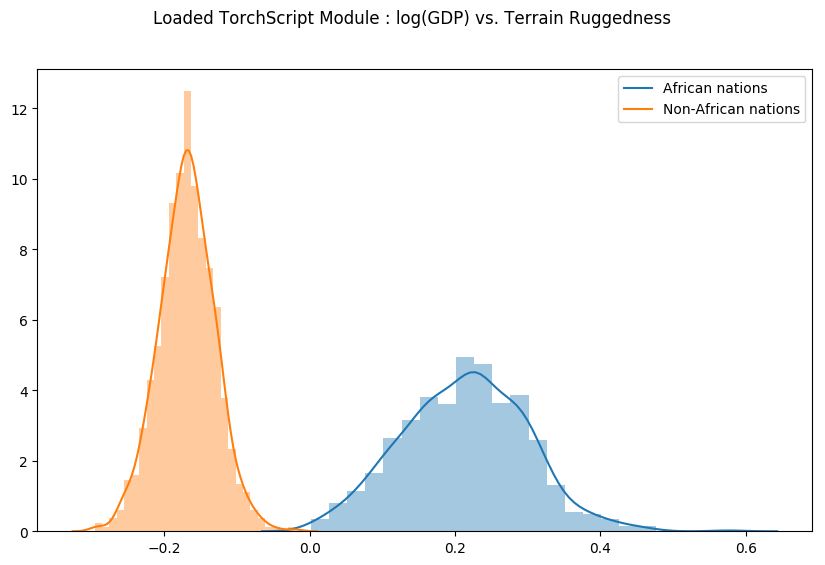

In [21]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])
weight = torch.stack(weight).detach()
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");


In the next section, we'll look at how to write guides for variational inference as well as compare the results with inference via HMC.

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012